In [ ]:
#hide
#default_exp visualization.experiment_visualization
from nbdev.showdoc import show_doc
import warnings
warnings.filterwarnings('ignore')

# Visualization utils

## Plot history

In [ ]:
#export
import numpy as np
#import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
from IPython.display import display
import visdom
from hpsearch.config.hpconfig import get_path_results, get_path_experiments
import hpsearch.utils.experiment_utils as ut
from hpsearch.visualization import plot_utils 
import warnings
warnings.filterwarnings('ignore')
    
              
def plot_multiple_histories (experiments, run_number=0, root_path=None, root_folder=None, metrics='all', 
                             metrics_second=[], parameters = None, compare = True, 
                             ylegend=0.5, name_file='model_history.pk', 
                             op='max', include_parameters_in_legend=False,
                             backend='visdom', **kwargs):
    
    if root_path is None:
        root_path = get_path_experiments(folder=root_folder)
    
    df = pd.read_csv('%s/experiments_data.csv' %root_path,index_col=0)
    df2 = ut.get_experiment_parameters (df.loc[experiments], only_not_null=True)
    parameters2, df2 = ut.get_parameters_unique(df2)

    if compare or parameters is not None:        
        if parameters is None:
            parameters = parameters2 
        df = df.loc[experiments,parameters]
    
    if type(metrics)==str and (metrics == 'all'):
        path_results = get_path_results (experiments[0], run_number=run_number, root_path=root_path)
        history = pickle.load(open('%s/%s' %(path_results, name_file),'rb'))
        metrics = history.keys()
    if type(metrics) == str:
        metrics = [metrics]
    if type(metrics_second) == str:
        metrics_second = [metrics_second]
    df = ut.replace_with_default_values (df)
    df2 = ut.replace_with_default_values (df2)
    df_show = df.copy()
    
    for (imetric,metric) in enumerate(metrics):
        title = metric
        traces = []
        for experiment_id in experiments:
            path_results = get_path_results (experiment_id, run_number=run_number, root_path=root_path)
            if os.path.exists('%s/%s' %(path_results, name_file)):
                history = pickle.load(open('%s/%s' %(path_results, name_file),'rb'))
                #values = [float(x) for x in history[metric]]
                if compare and include_parameters_in_legend:
                    label = '{}-{}'.format(experiment_id, list(dict(df.loc[experiment_id]).values()))
                else:
                    label = '{}'.format(experiment_id)
                traces = plot_utils.add_trace (history[metric], style='A.-', label=label, backend=backend, traces=traces)
                
                if True:
                    if op == 'min':
                        imin = int(np.array(history[metric]).argmin())
                    else:
                        imin = int(np.array(history[metric]).argmax())
                    vmin = float(history[metric][imin])
                    traces = plot_utils.add_trace ([imin], [vmin], style='.', label='', backend=backend, 
                                                   marker={'color': 'red', 'symbol': 104, 'size': 10},
                                                   traces=traces)
                    
                    title += ' [%d]: %.2f' %(experiment_id, vmin)
                    df_show.loc[experiment_id, metric] = vmin
                    df2.loc[experiment_id, metric] = vmin
                if (imetric == 0):
                    for metric_second in metrics_second:
                        #values = [float(x) for x in history[metric_second]]
                        if compare and include_parameters_in_legend:
                            label = '{}: {}-{}'.format(metric_second, experiment_id, list(dict(df.loc[experiment_id]).values()))
                        else:
                            label = '{}: {}'.format(metric_second, experiment_id)
                        traces = plot_utils.add_trace (history[metric_second], style='A.-', label=label, backend=backend, traces=traces)
                        
                        if op == 'min':
                            imin = int(np.array(history[metric_second]).argmin())
                        else:
                            imin = int(np.array(history[metric_second]).argmax())
                        vmin = float(history[metric_second][imin])
                        traces = plot_utils.add_trace ([imin], [vmin], style='.', label='', backend=backend, 
                                                   marker={'color': 'red', 'symbol': 104, 'size': 10},
                                                   traces=traces)
                        title += ' [%d]: %.2f' %(experiment_id, vmin)
                        df_show.loc[experiment_id, metric_second] = vmin
                        df2.loc[experiment_id, metric_second] = vmin

        plot_utils.plot(title=title, xlabel='epoch', ylabel=metric, traces=traces, backend=backend)
        if backend=='visdom':
            vis = visdom.Visdom()
            vis.text (df_show.to_html(justify='left', col_space=100), win= f'{metric}_parameters')
        display(df2)


In [ ]:
#collapse_output
from hpsearch.examples.dummy_experiment_manager import remove_previous_experiments, run_multiple_experiments

remove_previous_experiments()
run_multiple_experiments(nruns=5, noise=0.1)
run_multiple_experiments(nruns=5, noise=0.1, rate = 0.1)

experiment script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line: 180
processing hyper-parameter 0 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0009942054748535156
0 - validation_accuracy: 0.27926598888204995
0 - test_accuracy: 0.37116853691162743
finished experiment 0
processing hyper-parameter 0 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.000997304916381836
1 - validation_accuracy: 0.3137059084744178
1 - test_accuracy: 0.2756037415342204
finished experiment 0
processing hyper-param

current path: /mnt/athena/hpsearch/nbs/visualization
current path: /mnt/athena/hpsearch/nbs/visualization
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25


finished experiment 0
processing hyper-parameter 0 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0009582042694091797
3 - validation_accuracy: 0.4273100328604531
3 - test_accuracy: 0.2991516198816612
finished experiment 0
processing hyper-parameter 0 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0010068416595458984
4 - validation_accuracy: 0.10037652871806682
4 - test_accuracy: 0.3750686499164436
finished experiment 0
processing hyper-parameter 1 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
run

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007


finished experiment 1
processing hyper-parameter 1 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0010919570922851562
1 - validation_accuracy: 0.40595123363337116
1 - test_accuracy: 0.47926865120271667
finished experiment 1
processing hyper-parameter 1 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 2

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0012929439544677734
2 - validation_accuracy: 0.5284557348723119
2 - test_accuracy: 0.503334983552942
finished experiment 1
processing hyper-parameter 1 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
run

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
current path: /mnt/athena/hpsearch/nbs/visualization


running experiment 1
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0011012554168701172
4 - validation_accuracy: 0.5756390427991992
4 - test_accuracy: 0.5669994095092334
finished experiment 1
processing hyper-parameter 2 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0009534358978271484
0 - validation_accuracy: 0.6207498332609989
0 - test_accuracy: 0.9465589728725352
finished experiment 2
processing hyper-parameter 2 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpse

fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/visualization


script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0010313987731933594
2 - validation_accuracy: 0.6767798592387262
2 - test_accuracy: 0.8709883251192441
finished experiment 2
processing hyper-parameter 2 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0009090900421142578
3 - validation_accuracy: 0.7663820037837367
3 - test_accuracy: 0.9732108690991055
finished experiment 2
processing hyper-parameter 2 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experime

fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/visualization


script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.002054452896118164
0 - validation_accuracy: 0.5553807138764123
0 - test_accuracy: 0.5834310136313992
finished experiment 3
processing hyper-parameter 3 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0019190311431884766
1 - validation_accuracy: 0.4329241288245753
1 - test_accuracy: 0.5233026801585711
finished experiment 3
processing hyper-parameter 3 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experim

fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0023953914642333984
3 - validation_accuracy: 0.595532628836696
3 - test_accuracy: 0.3975501541932186
finished experiment 3
processing hyper-parameter 3 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0019779205322265625
4 - validation_accuracy: 0.7047990383831553
4 - test_accuracy: 0.4533623194438294
finished experiment 3
processing hyper-parameter 4 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experim

fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0021567344665527344
1 - validation_accuracy: 0.6254506206258286
1 - test_accuracy: 0.8064366426825922
finished experiment 4
processing hyper-parameter 4 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0022149085998535156
2 - validation_accuracy: 0.7953583890696541
2 - test_accuracy: 0.5769698582387975
finished experiment 4
processing hyper-parameter 4 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experi

fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0020933151245117188
4 - validation_accuracy: 0.7298685305117447
4 - test_accuracy: 0.6443386614889013
finished experiment 4
processing hyper-parameter 5 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0019648075103759766
0 - validation_accuracy: 1.0
0 - test_accuracy: 0.7886470874478337
finished experiment 5
processing hyper-parameter 5 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0020713

fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.002358675003051758
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 5
processing hyper-parameter 5 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0020542144775390625
3 - validation_accuracy: 0.8244342851035541
3 - test_accuracy: 0.9860824540650245
finished experiment 5
processing hyper-parameter 5 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.002051115036010742
4 - 

fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0036640167236328125
0 - validation_accuracy: 0.3387769460381838
0 - test_accuracy: 0.14383191030781514
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0036308765411376953
1 - validation_accuracy: 0.48934917507672415
1 - test_accuracy: 0.20918885421021916
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this exp

fitting model with 30 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
epoch 15: accuracy: 0.5800000000000003
epoch 16: accuracy: 0.6100000000000003
epoch 17: accuracy: 0.6400000000000003
epoch 18: accuracy: 0.6700000000000004
epoch 19: accuracy: 0.7000000000000004
epoch 20: accuracy: 0.6700000000000004
epoch 21: accuracy: 0.6400000000000003
epoch 22: accuracy: 0.6100000000000003
epoch 23: accuracy: 0.5800000000000003
epoch 24: accuracy: 0.5500000000000003
epoch 25: accuracy: 0.5200000000000002
epoch 26: accuracy: 0.4900000000000002
epoch 27:

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.003520488739013672
3 - validation_accuracy: 0.4698884151478717
3 - test_accuracy: 0.154574056329619
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0034296512603759766
4 - validation_accuracy: 0.2839417504678744
4 - test_accuracy: 0.18363908835696285
finished experiment 6
processing hyper-parameter 7 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experim

fitting model with 30 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
epoch 15: accuracy: 0.5800000000000003
epoch 16: accuracy: 0.6100000000000003
epoch 17: accuracy: 0.6400000000000003
epoch 18: accuracy: 0.6700000000000004
epoch 19: accuracy: 0.7000000000000004
epoch 20: accuracy: 0.6700000000000004
epoch 21: accuracy: 0.6400000000000003
epoch 22: accuracy: 0.6100000000000003
epoch 23: accuracy: 0.5800000000000003
epoch 24: accuracy: 0.5500000000000003
epoch 25: accuracy: 0.5200000000000002
epoch 26: accuracy: 0.4900000000000002
epoch 27:

running experiment 7
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0041351318359375
1 - validation_accuracy: 0.6393940368753838
1 - test_accuracy: 0.4275716725618324
finished experiment 7
processing hyper-parameter 7 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0035583972930908203
2 - validation_accuracy: 0.5096522809914014
2 - test_accuracy: 0.44376062880642747
finished experiment 7
processing hyper-parameter 7 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hps

fitting model with 30 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
epoch 15: accuracy: 0.7800000000000004
epoch 16: accuracy: 0.8100000000000004
epoch 17: accuracy: 0.8400000000000004
epoch 18: accuracy: 0.8700000000000004
epoch 19: accuracy: 0.9000000000000005
epoch 20: accuracy: 0.8700000000000004
epoch 21: accuracy: 0.8400000000000004
epoch 22: accuracy: 0.8100000000000004
epoch 23: accuracy: 0.7800000000000004
epoch 24: accuracy: 0.7500000000000003
epoch 25: accuracy: 0.720000000

running experiment 7
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.004287242889404297
4 - validation_accuracy: 0.4114817454372518
4 - test_accuracy: 0.3761258934816317
finished experiment 7
processing hyper-parameter 8 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0036923885345458984
0 - validation_accuracy: 0.7319007035082885
0 - test_accuracy: 0.8028149534318972
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hp

fitting model with 30 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
epoch 15: accuracy: 0.7800000000000004
epoch 16: accuracy: 0.8100000000000004
epoch 17: accuracy: 0.8400000000000004
epoch 18: accuracy: 0.8700000000000004
epoch 19: accuracy: 0.9000000000000005
epoch 20: accuracy: 0.8700000000000004
epoch 21: accuracy: 0.8400000000000004
epoch 22: accuracy: 0.8100000000000004
epoch 23: accuracy: 0.7800000000000004
epoch 24: accuracy: 0.7500000000000003
epoch 25: accuracy: 0.720000000

running experiment 8
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0036764144897460938
2 - validation_accuracy: 0.8395144655922936
2 - test_accuracy: 0.8570047544578
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.003947734832763672
3 - validation_accuracy: 0.9742442141247202
3 - test_accuracy: 0.8273460854237368
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsea

fitting model with 30 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
epoch 15: accuracy: 1.0800000000000003
epoch 16: accuracy: 1.1100000000000003
epoch 17: accuracy: 1.1400000000000003
epoch 18: accuracy: 1.1700000000000004
epoch 19: accuracy: 1.2000000000000004
epoch 20: accuracy: 1.1700000000000004
epoch 21: accuracy: 1.1400000000000003
epoch 22: accuracy: 1.1100000000000003
epoch 23: accuracy: 1.0800000000000003
epoch 24: accuracy: 1.0500000000000003
epoch 25: accuracy: 1.020000000000

experiment script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line: 180
processing hyper-parameter 0 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 9
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.00099945068359375
0 - validation_accuracy: 0.5881055924921881
0 - test_accuracy: 0.566229870520842
finished experiment 9
processing hyper-parameter 0 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 9
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0009539127349853516
1 - validation_accuracy: 0.420471888780363
1 - test_accuracy: 0.7306124893807233
finished experiment 9
processing hyper-parameter 0 


current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
current path: /mnt/athena/hpsearch/nbs/visualization


script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0010454654693603516
2 - validation_accuracy: 0.5697820666594738
2 - test_accuracy: 0.7125051791835613
finished experiment 9
processing hyper-parameter 0 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 9
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0009591579437255859
3 - validation_accuracy: 0.6610967375402188
3 - test_accuracy: 0.7024544166347816
finished experiment 9
processing hyper-parameter 0 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 9
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment

fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
current path: /mnt/athena/hpsearch/nbs/visualization


running experiment 10
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0010275840759277344
0 - validation_accuracy: 0.8400796317512461
0 - test_accuracy: 0.8829323437222805
finished experiment 10
processing hyper-parameter 1 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 10
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.001039743423461914
1 - validation_accuracy: 0.7876164149828687
1 - test_accuracy: 1.0
finished experiment 10
processing hyper-parameter 1 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 10
run number: 2

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/

fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization


running experiment 10
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.001146078109741211
3 - validation_accuracy: 0.9222606503647068
3 - test_accuracy: 0.7777313821266092
finished experiment 10
processing hyper-parameter 1 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 10
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0009522438049316406
4 - validation_accuracy: 0.836106916103745
4 - test_accuracy: 0.9952072707170627
finished experiment 10
processing hyper-parameter 2 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 11
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpse

fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization


running experiment 11
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0011098384857177734
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 11
processing hyper-parameter 2 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 11
run number: 2

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0009329319000244141
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 11
processing hyper-parameter 2 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 11
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line n

fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization


running experiment 11
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0010154247283935547
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 11
processing hyper-parameter 3 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 12
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0020189285278320312
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 12
processing hyper-parameter 3 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 12
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line

fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 13: accuracy: 1.5000000000000002
epoch 14: accuracy: 1.6000000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6:

processing hyper-parameter 3 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 12
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0009264945983886719
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 12
processing hyper-parameter 3 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 12
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.002151012420654297
3 - validation_accuracy: 1.0
3 - test_accuracy: 1.0
finished experiment 12
processing hyper-parameter 3 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values


current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 13: accuracy: 1.5000000000000002
epoch 14: accuracy: 1.6000000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: a

running experiment 12
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.002122640609741211
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 12
processing hyper-parameter 4 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 13
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0021686553955078125
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 13
processing hyper-parameter 4 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 13
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line

fitting model with 15 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 13: accuracy: 1.5000000000000002
epoch 14: accuracy: 1.6000000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: a

finished experiment 13
processing hyper-parameter 4 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 13
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0019600391387939453
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 13
processing hyper-parameter 4 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 13
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0017104148864746094
3 - validation_accuracy: 1.0
3 - test_accuracy: 1.0
finished experiment 13
processing hyper-parameter 4 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values


current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004
epoch 14: accuracy: 1.8000000000000005
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.

running experiment 13
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.002565622329711914
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 13
processing hyper-parameter 5 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 14
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.002004861831665039
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 14
processing hyper-parameter 5 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 14
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line 

fitting model with 15 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004
epoch 14: accuracy: 1.8000000000000005
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.80000000

finished experiment 14
processing hyper-parameter 5 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 14
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.00202178955078125
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 14
processing hyper-parameter 5 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 14
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0023355484008789062
3 - validation_accuracy: 1.0
3 - test_accuracy: 1.0
finished experiment 14
processing hyper-parameter 5 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values


current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.8000000000000005
epoch 12: accuracy: 1.9000000000000006
epoch 13: accuracy: 2.0000000000000004
epoch 14: accuracy: 2.1000000000000005
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: 

running experiment 14
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0020673274993896484
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 14
processing hyper-parameter 6 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 15
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0029726028442382812
0 - validation_accuracy: 1.0
0 - test_accuracy: 0.8879746612500439
finished experiment 15
processing hyper-parameter 6 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 15
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_

fitting model with 15 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.8000000000000005
epoch 12: accuracy: 1.9000000000000006
epoch 13: accuracy: 2.0000000000000004
epoch 14: accuracy: 2.1000000000000005
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 30 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch

1 - test_accuracy: 0.9674160974511479
finished experiment 15
processing hyper-parameter 6 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 15
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0039997100830078125
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 15
processing hyper-parameter 6 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 15
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0034775733947753906
3 - validation_accuracy: 1.0
3 - test_accuracy: 0.892248582032179
finished experiment 15
processing hyper-parameter 6 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values


current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 30 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 13: accuracy: 1.5000000000000002
epoch 14: accuracy: 1.6000000000000003
epoch 15: accuracy: 1.7000000000000004
epoch 16: accuracy: 1.8000000000000005
epoch 17: accuracy: 1.9000000000000006
epoch 18: accuracy: 2.0000000000000004
epoch 19: accuracy: 2.1000000000000005
epoch 20: accuracy: 2.0000000000000004
epoch 21: accuracy: 1.9000000000000004
epoch 22: accuracy: 1.8000000000000003
epoch 23: accuracy: 1.7000000000000002
epoch 24: accuracy: 1.6
epoch 25: accuracy: 1.5
epoch 26: accuracy: 1.4
epoch 27: accuracy: 1.29

running experiment 15
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0036695003509521484
4 - validation_accuracy: 1.0
4 - test_accuracy: 0.9426325611045316
finished experiment 15
processing hyper-parameter 7 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 16
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0037026405334472656
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 16
processing hyper-parameter 7 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 16
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_

fitting model with 30 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 13: accuracy: 1.5000000000000002
epoch 14: accuracy: 1.6000000000000003
epoch 15: accuracy: 1.7000000000000004
epoch 16: accuracy: 1.8000000000000005
epoch 17: accuracy: 1.9000000000000006
epoch 18: accuracy: 2.0000000000000004
epoch 19: accuracy: 2.1000000000000005
epoch 20: accuracy: 2.0000000000000004
epoch 21: accuracy: 1.9000000000000004
epoch 22: accuracy: 1.8000000000000003
epoch 23: accuracy: 1.7000000000000002
epoch 24: accuracy: 1.6
epoch 25: accuracy: 1.5
epoch 26: accuracy: 1.4
epoch 27: accuracy: 1.2999999999999998
epoch 28: accuracy: 1.1999999999999997

time spent on this experiment: 0.0035419464111328125
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 16
processing hyper-parameter 7 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 16
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0034606456756591797
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 16
processing hyper-parameter 7 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 16
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.003596782684326172
3 - validation_accuracy: 1.0
3 - test_accuracy: 1.0
finished experiment 16



epoch 21: accuracy: 2.1000000000000005
epoch 22: accuracy: 2.0000000000000004
epoch 23: accuracy: 1.9000000000000004
epoch 24: accuracy: 1.8000000000000003
epoch 25: accuracy: 1.7000000000000002
epoch 26: accuracy: 1.6
epoch 27: accuracy: 1.5
epoch 28: accuracy: 1.4
epoch 29: accuracy: 1.2999999999999998
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 30 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004
epoch 14: accuracy: 1.8000000000000005
epoch 15: accuracy: 1.9000000000000006
epoch 16: accuracy: 2.0000000000000004
epoch 17: accuracy: 2.1000000000000005
epoch 18:

processing hyper-parameter 7 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 16
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.003403902053833008
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 16
processing hyper-parameter 8 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 17
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.004008769989013672
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 17
processing hyper-parameter 8 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values


current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 30 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004
epoch 14: accuracy: 1.8000000000000005
epoch 15: accuracy: 1.9000000000000006
epoch 16: accuracy: 2.0000000000000004
epoch 17: accuracy: 2.1000000000000005
epoch 18: accuracy: 2.2000000000000006
epoch 19: accuracy: 2.3000000000000007
epoch 20: accuracy: 2.2000000000000006
epoch 21: accuracy: 2.1000000000000005
epoch 22: accuracy: 2.0000000000000004
epoch 23: accuracy: 1.9000000000000004
epoch 24: accuracy: 1.8000000000000003
epoch 25: accuracy: 1.7000000000000002
epoc

running experiment 17
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0037534236907958984
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 17
processing hyper-parameter 8 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 17
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0008330345153808594
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 17
processing hyper-parameter 8 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 17
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, lin

fitting model with 30 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.8000000000000005
epoch 12: accuracy: 1.9000000000000006
epoch 13: accuracy: 2.0000000000000004
epoch 14: accuracy: 2.1000000000000005
epoch 15: accuracy: 2.2000000000000006
epoch 16: accuracy: 2.3000000000000007
epoch 17: accuracy: 2.400000000000001
epoch 18: accuracy: 2.500000000000001
epoch 19: accuracy: 2.600000000000001
epoch 20: accuracy: 2.500000000000001
epoch 21: accuracy: 2.400000000000001
epoch 22: accuracy: 2.3000000000000007
epoch 23: accuracy: 2.2000000000000006
epoch 24: accuracy: 2.1000000000000005
epoch 25: accuracy: 2.0000000000000004
epoch 26: accurac

finished experiment 17
processing hyper-parameter 8 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 17
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0040247440338134766
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 17


current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 30 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.8000000000000005
epoch 12: accuracy: 1.9000000000000006
epoch 13: accuracy: 2.0000000000000004
epoch 14: accuracy: 2.1000000000000005
epoch 15: accuracy: 2.2000000000000006
epoch 16: accuracy: 2.3000000000000007
epoch 17: accuracy: 2.400000000000001
epoch 18: accuracy: 2.500000000000001
epoch 19: accuracy: 2.600000000000001
epoch 20: accuracy: 2.500000000000001
epoch 21: accuracy: 2.400000000000001
epoch 22: accuracy: 2.3000000000000007
epoch 23: accuracy: 2.2000000000000006
epoch 24: accuracy: 2.1000000000000005
epo

### Usage examples

Plot all the metrics that have been stored in model_history

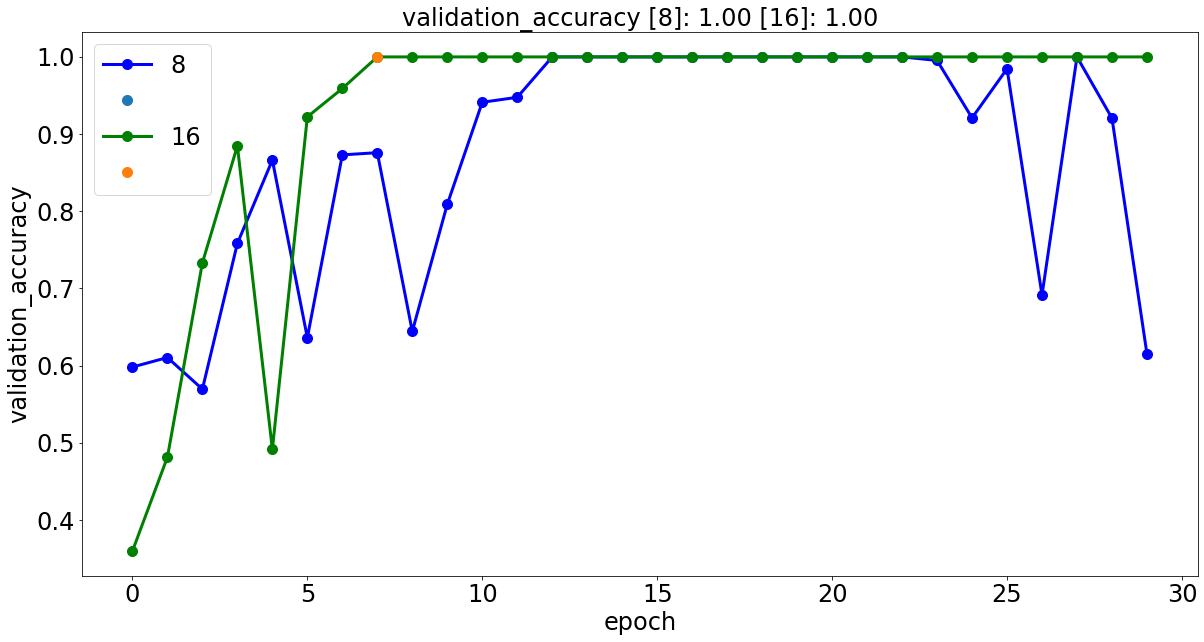

,offset,rate,validation_accuracy
8,0.6,0.03,1.0
16,0.3,0.10,1.0


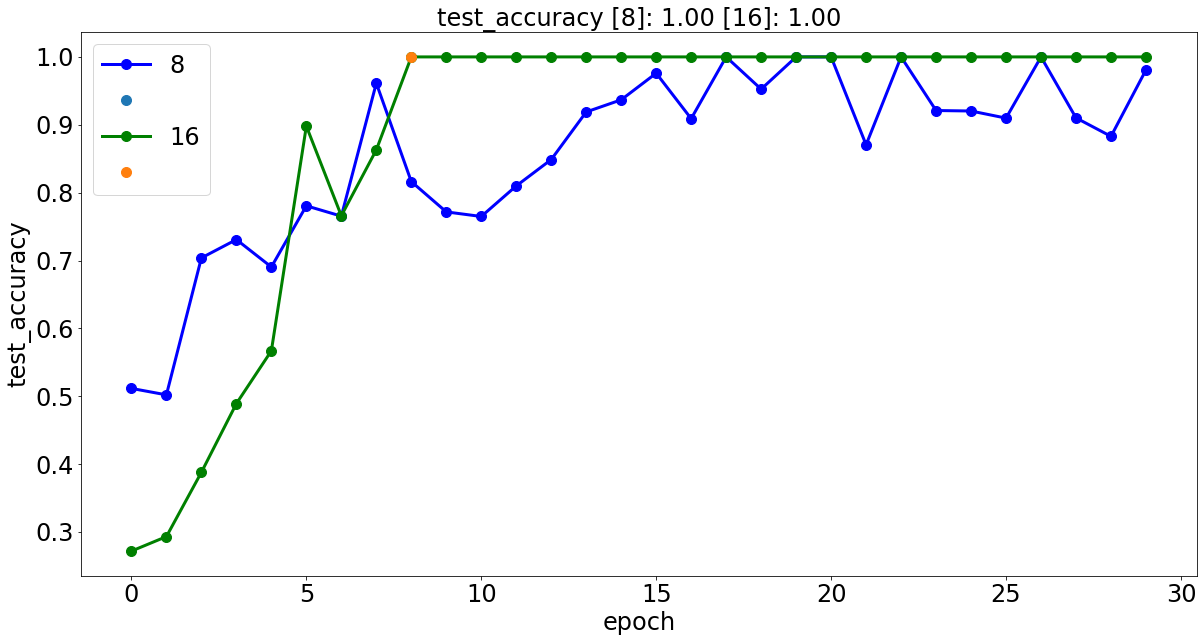

,offset,rate,validation_accuracy,test_accuracy
8,0.6,0.03,1.0,1.0
16,0.3,0.10,1.0,1.0


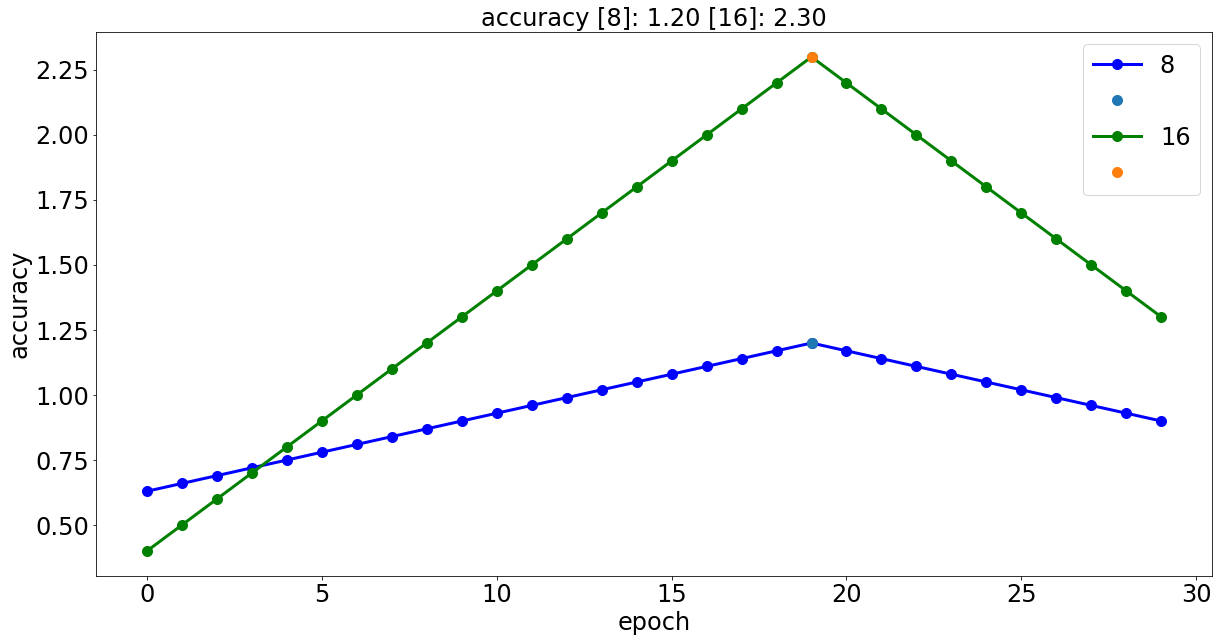

,offset,rate,validation_accuracy,test_accuracy,accuracy
8,0.6,0.03,1.0,1.0,1.2
16,0.3,0.10,1.0,1.0,2.3


In [ ]:
plot_multiple_histories ([8,16], run_number=0, op='max', backend='matplotlib')

### Plot only one metric, and three experiments

We plot the test_accuracy metric

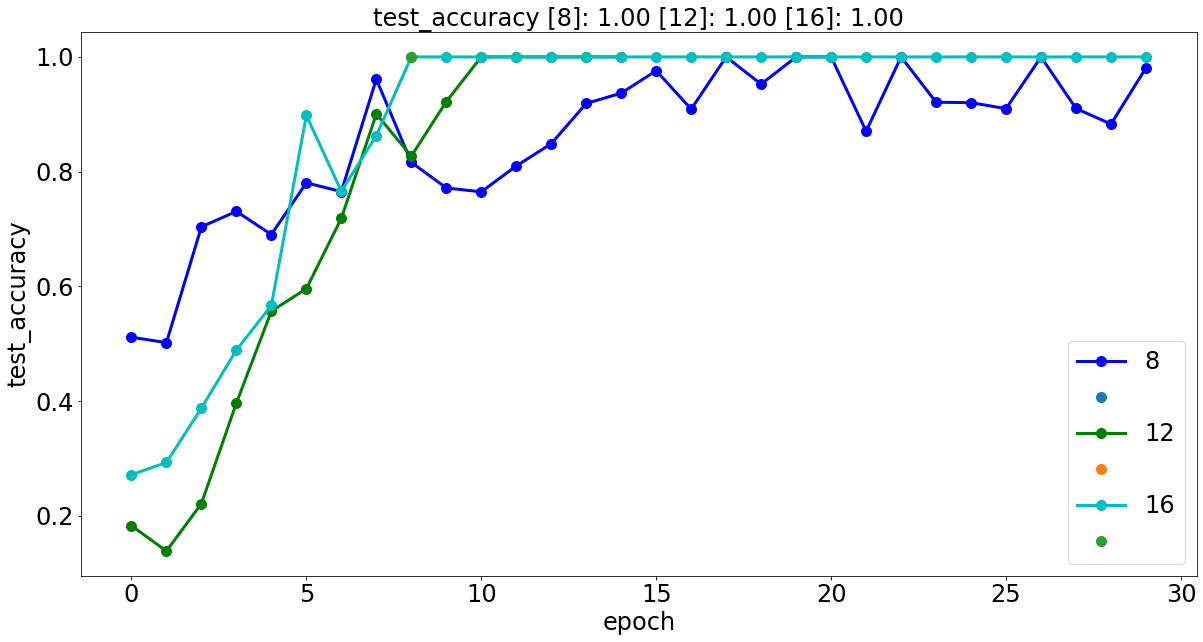

,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0


In [ ]:
plot_multiple_histories ([8,12, 16], run_number=0, op='max', metrics = 'test_accuracy', backend='matplotlib')

### Use plotly as backend

In [ ]:
plot_multiple_histories ([8,12, 16], run_number=0, op='max', metrics = 'test_accuracy', backend='plotly')

,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0


## Metric correlation

Displays the relationship between scores obtained across experiments with two different evaluation metrics indicated as argument. Calculates Pearson R-squared coefficient.

In [ ]:
#export

def plot_metric_relationship (metric_1, metric_2, folder_experiments=None, run_numbers=None, 
                              experiments=None, experiment_subset=None,
                              backend='visdom', **kwargs):
    df = ut.get_experiment_data (folder_experiments=folder_experiments, experiments=experiments)
    df_metric_1 = ut.get_experiment_scores (experiment_data=df, suffix_results=f'_{metric_1}', remove_suffix=True, class_ids=run_numbers)
    df_metric_2 = ut.get_experiment_scores (experiment_data=df, suffix_results=f'_{metric_2}', remove_suffix=True, class_ids=run_numbers)
    
    traces=plot_utils.add_trace(df_metric_1.values, df_metric_2.values, traces=[], style='A.', label='all experiments', backend=backend);
    
    if experiment_subset is not None:
        df_metric_1_subset = ut.get_experiment_scores (experiment_data=df.loc[experiment_subset], suffix_results=f'_{metric_1}', remove_suffix=True, class_ids=run_numbers)
        df_metric_2_subset = ut.get_experiment_scores (experiment_data=df.loc[experiment_subset], suffix_results=f'_{metric_2}', remove_suffix=True, class_ids=run_numbers)
        traces=plot_utils.add_trace(df_metric_1_subset.values, df_metric_2_subset.values, traces=traces, style='A.', label=f'selected subset', backend=backend);
    
    plot_utils.plot(np.linspace(df_metric_1.values.min(), df_metric_1.values.max(), 100), 
                np.linspace(df_metric_2.values.min(), df_metric_2.values.max(), 100), 
                traces=traces, style='A-', label='linear', title=f'{metric_1} vs {metric_2}', xlabel=metric_1, ylabel=metric_2, backend=backend);

## usage examples

Illustrate usage based on dummy experiment manager

#### plot relationship between validation and accuracy metrics

In [ ]:
plot_metric_relationship ('validation_accuracy', 'test_accuracy', backend='plotly')

#### 3. Highlight selected experiments

In [ ]:
plot_metric_relationship ('validation_accuracy', 'test_accuracy', experiment_subset=[5,2], backend='plotly')

## visualize_experiments

Main experiment visualization entry function

In [ ]:
#export
## Generic Visualization
def visualize_experiments (visualization='history', **kwargs):
    if type(visualization) is str:
        visualization_list = [visualization]
    else:
        visualization_list = visualization
    for visualization in visualization_list:
        parameters = kwargs.copy()
        if visualization == 'history':
            assert 'experiments' in kwargs.keys(), 'experiments parameter expected when visualization is "history"'
            experiments = parameters.pop('experiments')
            plot_multiple_histories (experiments, **parameters)
        elif visualization == 'metric_correlation':
            assert 'metric_1' in kwargs.keys(), 'metric_1 parameter expected when visualization is "metric_correlation"'
            assert 'metric_2' in kwargs.keys(), 'metric_2 parameter expected when visualization is "metric_correlation"'
            metric_1 = parameters.pop('metric_1')
            metric_2 = parameters.pop('metric_2')
            plot_metric_relationship (metric_1, metric_2, **parameters)
        else:
            from hpsearch.config.hpconfig import experiment_visualization

            experiment_visualization (visualization=visualization, **kwargs)

,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0


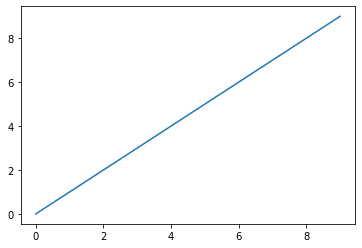

In [ ]:
visualize_experiments (visualization=['history', 'metric_correlation', 'custom'], experiments=[8,12, 16], 
                       run_number=0, op='max', metrics = 'test_accuracy', backend='plotly',
                       metric_1='test_accuracy', metric_2='validation_accuracy')

In [ ]:
#hide
from nbdev.export import *
notebook2script(recursive=True)

Converted hpconfig.ipynb.
Converted manager_factory.ipynb.
Converted dummy_experiment_manager.ipynb.
Converted example_experiment.ipynb.
Converted example_experiment_manager.ipynb.
Converted experiment_manager.ipynb.
Converted index.ipynb.
Converted change_manager.ipynb.
Converted metric_visualization.ipynb.
Converted print_parameters.ipynb.
Converted query.ipynb.
Converted experiment_utils.ipynb.
Converted organize_experiments.ipynb.
Converted experiment_visualization.ipynb.
Converted plot_utils.ipynb.
